# **Exucute Query using the NEIVA Database**

###**1. Create a `mysql` server in the Colab environment.**


In [ ]:
!pip install mysql-connector-python # Install the necessary package to connect Python with MySQL databases.
!apt-get -y install mysql-server    # Install the MySQL server on the Colab environment.
!service mysql start                # With MySQL install, this starts the server.

# Setting the password. Here 'root' is used as password.

!mysql -e "ALTER USER 'root'@'localhost' IDENTIFIED WITH 'mysql_native_password' BY 'root';FLUSH PRIVILEGES;"

### **2. Create the NEIVA database in the `mysql` server.**

In [ ]:
# Upload the database files. This will provide a 'upload' button. Upload all the database (.sql) files.
# Note: For best results, use google chrome to run the notebook.
from google.colab import files
uploaded = files.upload()

In [3]:
# Check if the sql files are uploaded.
!ls *.sql

backend_db.sql	legacy_db.sql  neiva_output_db.sql  primary_db.sql  raw_db.sql


In [ ]:
# Load the database files into the mysql server. (Note: Do not change the database names).
!mysql -u root -proot -e "CREATE DATABASE IF NOT EXISTS backend_db"
!mysql -u root -proot backend_db < backend_db.sql
!mysql -u root -proot -e "CREATE DATABASE IF NOT EXISTS legacy_db"
!mysql -u root -proot legacy_db < legacy_db.sql
!mysql -u root -proot -e "CREATE DATABASE IF NOT EXISTS neiva_output_db"
!mysql -u root -proot neiva_output_db < neiva_output_db.sql
!mysql -u root -proot -e "CREATE DATABASE IF NOT EXISTS primary_db"
!mysql -u root -proot primary_db < primary_db.sql
!mysql -u root -proot -e "CREATE DATABASE IF NOT EXISTS raw_db"
!mysql -u root -proot raw_db < raw_db.sql

In [5]:
# Check if the databases are available in the mysql server.
!mysql -u root -proot -e "show databases"

mysql: [Warning] Using a password on the command line interface can be insecure.
+--------------------+
| Database           |
+--------------------+
| backend_db         |
| information_schema |
| legacy_db          |
| mysql              |
| neiva_output_db    |
| performance_schema |
| primary_db         |
| raw_db             |
| sys                |
+--------------------+


In [6]:
# Querying the tables of a database.
!mysql -u root -proot -e "use neiva_output_db; show tables;"

mysql: [Warning] Using a password on the command line interface can be insecure.
+---------------------------+
| Tables_in_neiva_output_db |
+---------------------------+
| Integrated_EF             |
| Processed_EF              |
| Recommended_EF            |
| property                  |
+---------------------------+


In [7]:
# Establishing connection with MySQL database
import mysql.connector

def connect_db(db):
  con = mysql.connector.connect(user='root', password='root', host='localhost', database=db)
  return con

legacy_db=connect_db('legacy_db')
raw_db=connect_db('raw_db')
primary_db=connect_db('primary_db')
output_db=connect_db('neiva_output_db')
backend_db=connect_db('backend_db')

###**3. Execute Query from Python**

**Example 1: Querying the PM 2.5, OC, BC data of a specific fire type**

In [ ]:
##_______ Example 1: Querying The PM2.5, OC, BC EF data of a specific fire type ___________##
import pandas as pd

# Importing the integrated EF dataset
intdf=pd.read_sql('select * from Integrated_EF', con=output_db)
# Importing the information table associated to the 'Integrated EF' dataset
efcoldf=pd.read_sql('select * from bkdb_info_efcol', con=backend_db)

efcol=list(efcoldf['efcol']) # EF columns

# Aligning BC data
ind=intdf[intdf['id']=='BC'].index[0]
efcoldf['bc']=intdf[efcol].iloc[ind].values

# Aligning OC data
ind=intdf[intdf['id']=='OC'].index[0]
efcoldf['oc']=intdf[efcol].iloc[ind].values

# Aligning PM2.5 data
ind=intdf[intdf['id']=='PM2.5'].index[0]
efcoldf['pm']=intdf[efcol].iloc[ind].values

In [10]:
# Querying emission factor (EF) of BC for a specific fire type (e.g., open cooking)
efcoldf2=efcoldf[efcoldf['bc'].notna()]
efcoldf2[['legend','fuel_type', 'measurement_type','MCE', 'bc']][efcoldf2['fire_type']=='open cooking']

,legend,fuel_type,measurement_type,MCE,bc
22,Akagi_11(Christian et al 10),mixed fuel,field,0.949,0.4800
25,Akagi_11(Roden et al 06),mixed fuel,field,0.896,1.1700
26,Akagi_11(Roden et al 09),mixed fuel,field,0.917,0.8500
28,Akagi_11(Johnson et al 08),mixed fuel,field,0.949,0.8300
60,Stockwell et al 16,twig,lab,0.955,0.1403
75,Stockwell et al 16,hardwood,lab,0.955,0.0975


In [11]:
# Querying EF of OC for a specific fire type (e.g., open cooking)
efcoldf2=efcoldf[efcoldf['oc'].notna()]
efcoldf2[['legend','fuel_type', 'measurement_type','MCE', 'oc']][efcoldf2['fire_type']=='open cooking']

,legend,fuel_type,measurement_type,MCE,oc
22,Akagi_11(Christian et al 10),mixed fuel,field,0.949,2.05
25,Akagi_11(Roden et al 06),mixed fuel,field,0.896,3.47
26,Akagi_11(Roden et al 09),mixed fuel,field,0.917,3.12
28,Akagi_11(Johnson et al 08),mixed fuel,field,0.949,2.90
85,Coffey et al 17,hardwood,field,0.933,2.10
133,Jayarathne et al 18,mixed fuel,field,0.861,13.00


In [12]:
# Querying EF of OC for a specific fire type (e.g., Cookstove)
efcoldf2=efcoldf[efcoldf['bc'].notna()]
efcoldf2[['fuel_type', 'measurement_type', 'MCE','cookstove_name', 'bc']][efcoldf2['fire_type']=='cookstove']

,fuel_type,measurement_type,MCE,cookstove_name,bc
12,mixed fuel,field,0.950,patsari,0.7400
55,hardwood,field,0.933,mudstove,0.3103
58,hardwood,lab,0.966,mudstove,0.3225
59,hardwood,lab,0.975,forced draft,0.1071
61,hardwood,lab,0.984,envirotek stove,0.6764
67,hardwood,field,0.914,mudstove,0.1313
69,hardwood,lab,0.983,chimney stove,0.1692
70,biogas,lab,0.954,biogas stove,0.0033
71,biobriquette,lab,0.985,biobriquette stove,0.0064
97,hardwood,field,NaN,mudstove,0.2080


**Example 2: Querying the Recommended EF table for a specific pollutant category**

In [ ]:
# Importing the integrated EF dataset
rdf=pd.read_sql('select * from Recommended_EF', con=output_db)

# List of pollutant Category
pc_list=list(rdf['pollutant_category'].unique())

In [14]:
pc_list

['inorganic gas',
 'methane',
 'NMOC_g',
 'PM total',
 'PM carbon',
 'PM ion',
 'PM metal',
 'NMOC_p:polycyclic aromatic hc',
 'NMOC_p:hopane',
 'NMOC_p:n alkane',
 'NMOC_p:anhydrosugar',
 'NMOC_p:lignin decomposition product',
 'NMOC_p:sterol stanol',
 'NMOC_p:tricyclic terpane',
 'PM optical property']

In [15]:
# Selecting the optical property data for 'peat' fire type.
rdf[['compound','AVG_peat']][rdf['pollutant_category']=='PM optical property']

,compound,AVG_peat
1270,EF B abs 870 (m2 kg 1),0.0192
1271,EF B scat 870 (m 2 kg 1),10.7208
1272,EF Babs 405 (m2 kg1),1.3500
1273,EF B 405 (m2 kg1scat ),50.6000
1274,EF Babs 405 just BrC (m2 kg1),1.3000
1275,EF Babs 405 just BC (m2 kg1),0.0540
1276,SSA 870 nm,0.9970
1277,SSA 405 nm,0.9480
1278,AAE,6.3255
1279,SSA 532,0.9913


In [16]:
# Selecting the NMOC_p data for 'open cooking' fire type.
rdf[['compound','AVG_open_cooking']][rdf['pollutant_category']=='NMOC_p:polycyclic aromatic hc']

,compound,AVG_open_cooking
1196,Phenanthrene,0.0005
1197,Anthracene,NaN
1198,Fluoranthene,0.0021
1199,Pyrene,0.0025
1200,Methylfluoranthene,0.0010
1201,9-Methylanthracene,0.0004
1202,Benzo(ghi)fluoranthene,0.0013
1203,Cyclopenta(cd)pyrene,0.0008
1204,Benz(a)anthracene,0.0018
1205,Chrysene,0.0017


**Example 3: Qyerying the NMOC_g data from the Integrated EF dataset**

In [ ]:
# Install the PubChemPy package
!pip install pubchempy
import pubchempy as pcp

In [18]:
# Specify a compound name and fire type
compound='phenol'
# fetch InChI from PubChemPy
iid=pcp.get_compounds(compound, 'name')[0].inchi
ind=intdf[intdf['id']==iid].index[0]

# The EF columns
efcol=list(efcoldf['efcol'])

efcoldf['phenol']=intdf[efcol].iloc[ind].values

In [20]:
# Quering for a specific fire type
efcoldf2=efcoldf[efcoldf['phenol'].notna()]
efcoldf2[['legend', 'measurement_type','phenol']][efcoldf2['fire_type']=='boreal forest']


,legend,measurement_type,phenol
0,Akagi_11(Bertschi et al 03),lab,3.2000
1,Akagi_11(Yokelson et al 97),lab,2.3400
2,Akagi_11(Bertschi et al 03),lab,3.4000
4,Akagi_11(Yokelson et al 97),lab,7.9900
50,Hayden et al 22,field,0.1200
110,Hatch et al 15,lab,0.1251
208,Stockwell et al 15,lab,0.1954


**Example 4: Querying NMOC_g data from Processed EF dataset**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

pp=pd.read_sql('select * from Processed_EF', con=output_db)
# Importing the assocaited information table.
efcoldf_pp=pd.read_sql('select * from info_efcol_processed_data', con=backend_db)

# Specify a compound name and fire type
compound='furan'
ft = 'crop residue'

# fetch InChI from PubChemPy
iid=pcp.get_compounds(compound, 'name')[0].inchi
ind=pp[pp['id']==iid].index[0]

# Get the EF of Furan for crop residue
efcol=list(efcoldf_pp['efcol'])
efcoldf_pp['furan']=pp[efcol].iloc[ind].values
ef_vals=efcoldf_pp['furan'][efcoldf_pp['fire_type']==ft].dropna().values
legend=list(efcoldf_pp['legend'][efcoldf_pp['fire_type']==ft][efcoldf_pp['furan'].notna()])

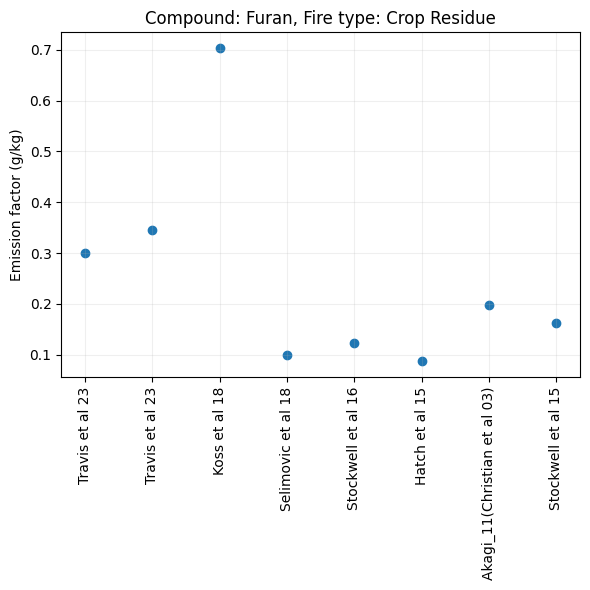

In [22]:
# Plot
plt.figure(figsize=(6,6))
ax = plt.subplot(111)
plt.scatter(np.arange(len(ef_vals)), ef_vals)
plt.ylabel('Emission factor (g/kg)')
plt.title("Compound: Furan, Fire type: Crop Residue")
plt.xticks(np.arange(len(ef_vals)), legend, rotation=90)
plt.grid(alpha=0.2)
plt.tight_layout()

**Example 5: Querying speciation of the model surrogates**

In [ ]:
# Import Recommended EF dataset
rdf=pd.read_sql('select * from Recommended_EF', con=output_db)
# Import Surrogate_Property EF dataset
prdf=pd.read_sql('select * from property', con=output_db)

# Non-methane organic compounds in gas phase.
nmog=rdf[rdf['pollutant_category']=='NMOC_g']

# Merging the Property dataset
nmog=nmog.merge(prdf[prdf.columns[3:]], on='id', how='left')

In [30]:
# The Speciation compunds of ARO1 model species
nmog[['S07','compound','AVG_boreal_forest','AVG_peat','kOH', 'vp']][nmog['S07']=='ARO1']

,S07,compound,AVG_boreal_forest,AVG_peat,kOH,vp
150,ARO1,Pyridine,0.019600,0.120450,5.310000e-13,20.800000
204,ARO1,Thiophene,0.004900,0.021000,9.530000e-12,79.700000
280,ARO1,Toluene,1.535000,0.782700,5.930000e-12,28.400000
322,ARO1,2-Furaldehyde,0.535700,1.085175,3.510000e-11,2.210000
373,ARO1,"Thiophene, 2-methyl-",NaN,0.019550,2.501500e-11,24.900000
376,ARO1,2-furan methanol,0.251000,0.329700,1.040454e-10,0.609000
431,ARO1,ethylbenzene,0.068961,0.133168,7.000000e-12,9.600000
457,ARO1,Anisole,0.015777,NaN,1.730000e-11,3.540000
465,ARO1,5-methyl furfural,0.123000,0.466150,5.100000e-11,0.686000
557,ARO1,Benzofuran,0.040000,0.048500,3.730000e-11,0.440000
